In [1]:
import numpy as np
import torch
import torchvision

In [2]:
# check if GPU is accessible with pytorch
torch.cuda.is_available()

True

In [3]:
# command to check GPU status
!nvidia-smi

Fri Sep 30 16:56:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#downloading training and test datasets

trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

In [5]:
print(len(trainingdata))
print(len(testdata))

60000
10000


In [6]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


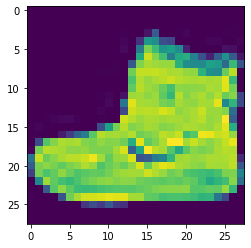

In [7]:
#plot one of them
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.squeeze().numpy())
plt.show()

In [8]:
#define batch size and use data loaders
batch_size = 64

trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=batch_size,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=batch_size,shuffle=False)

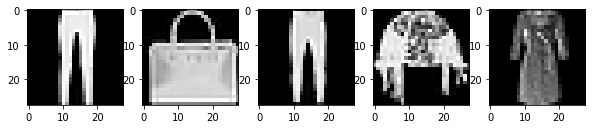

In [9]:
#plot 5 images
images, labels = iter(trainDataLoader).next()

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.imshow(images[index].squeeze().numpy(),cmap=plt.cm.gray)

**BUILDING THE NETWORK**

In [10]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.hidden1 = torch.nn.Linear(784,256) #784 = 28*28 #mnist set is 28x28
    self.hidden2 = torch.nn.Linear(256,128)
    self.hidden3 = torch.nn.Linear(128,64)
    self.output  = torch.nn.Linear(64,10) #output 10 class

  def forward(self, x):
    x = x.view(-1,28*28) #flattening using view function
    x = torch.relu(self.hidden1(x)) #relu activation for the hidden layers
    x = torch.relu(self.hidden2(x))
    x = torch.relu(self.hidden3(x))
    x = self.output(x)

    return x

In [11]:
#define hyperparameters
model = NeuralNetwork().cuda()
Loss = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

**TRAIN THE MODEL**

In [12]:
train_loss_history = []
test_loss_history = []
predictions_list = []

epoch = 50
for epochs in range(epoch):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = model(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()

  correct = 0
  total = 0
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = model(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()

      _, label = torch.max(predicted_output, 1)
      correct += (label == labels).sum().item()
      total += len(labels)


  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  accuracy = 100* correct / total
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Epoch %s, Train loss %s, Test loss %s'%(epochs+1, train_loss, test_loss))
print('Test accuracy is %s'%(accuracy))

Epoch 1, Train loss 1.8398020198858622, Test loss 1.0890956558998983
Epoch 2, Train loss 0.8588040916840913, Test loss 0.7872043346903127
Epoch 3, Train loss 0.6839703025340017, Test loss 0.6781664538155695
Epoch 4, Train loss 0.5997406714188773, Test loss 0.6233118396655769
Epoch 5, Train loss 0.5462736960794372, Test loss 0.5780041246277512
Epoch 6, Train loss 0.5104824260576193, Test loss 0.538612003918666
Epoch 7, Train loss 0.48484779808567025, Test loss 0.49090078435126383
Epoch 8, Train loss 0.46494785013165807, Test loss 0.47882444539647195
Epoch 9, Train loss 0.4481035707983127, Test loss 0.5066130531441634
Epoch 10, Train loss 0.43361046471829606, Test loss 0.46370499509914664
Epoch 11, Train loss 0.4217175666902111, Test loss 0.45365338691860246
Epoch 12, Train loss 0.4103229732147412, Test loss 0.45603394755132637
Epoch 13, Train loss 0.4006686931384652, Test loss 0.4252592354633246
Epoch 14, Train loss 0.39293848602438786, Test loss 0.43494533695233095
Epoch 15, Train loss

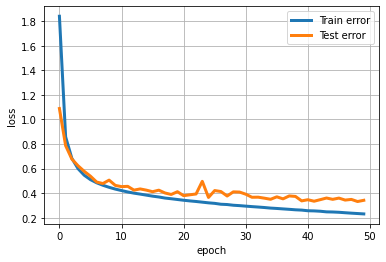

In [13]:
plt.plot(range(epoch),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(epoch),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [14]:
print('Test accuracy is %s'%(accuracy))

Test accuracy is 87.78


Model's test accuracy is 87.78%

Also, from the graph we can observe that our model is learning. (Loss is gettin smaller.)

Also, no overfitting is observed in the data. (Typically test or validation loss should be similar to but slightly higher than training loss. Our graph looks good.)

# Finding Class Probabilities

I'm using softmax to find class probabilities.

In [63]:
#I used sigmoid function to find class probabilities.
sm = torch.nn.Softmax(dim=1)
predicted_output = model(images)
probabilities = sm(predicted_output).cpu().detach().numpy() 

Text(0.5, 1.0, '0.99942446')

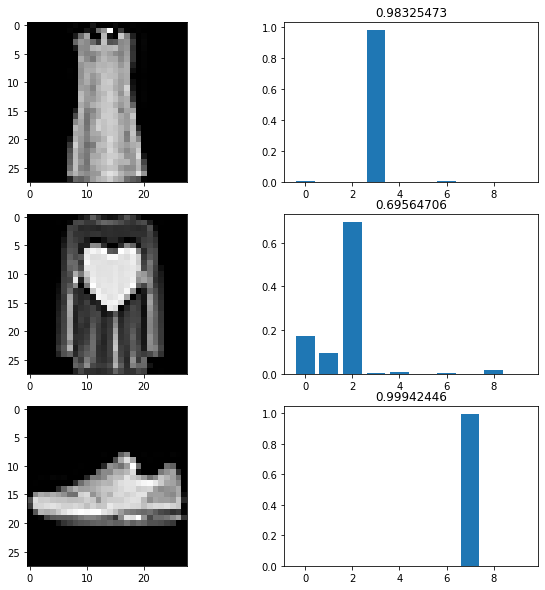

In [66]:
X = list(range(0, 10)) #we have 10 classes, we will use this for bar plot.
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.imshow(images[0].cpu().squeeze().numpy(),cmap=plt.cm.gray) #draws and plots the image 0 in the set.
plt.subplot(3,2,2)
plt.bar(X, probabilities[0]) #graphs the 
plt.title(probabilities[0].max())

plt.subplot(3,2,3)
plt.imshow(images[1].cpu().squeeze().numpy(),cmap=plt.cm.gray)
plt.subplot(3,2,4)
plt.bar(X, probabilities[1])
plt.title(probabilities[1].max())

plt.subplot(3,2,5)
plt.imshow(images[2].cpu().squeeze().numpy(),cmap=plt.cm.gray)
plt.subplot(3,2,6)
plt.bar(X, probabilities[2])
plt.title(probabilities[2].max())

I printed first 3 images and related probabilities using sigmoid function. Accordingly, for the first image highest probability occurs at class 3 (0.983) so our model classify this as label 3. (Probably a dress). If we check below, I also printed actual labels and predicted labels and it shows that actual label is also label 3. Our model classified the image correctly.

Similarly, for the second image highest probability occurs at class 2 (0.695); the probability is a bit low since even for us, it is not very clear if it's a shirt or not. Also, for the third image highest probability occurs at class 7 (0.999). 

Based on the labels shown below, our model classified all three images correctly.


In [16]:
#checking class labels
predicted_output = model(images)
_,p_label = torch.max(predicted_output, 1)
print('Actual labels %s'%(labels))
print('Predicted labels %s'%(p_label))


Actual labels tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')
Predicted labels tensor([3, 2, 7, 5, 8, 4, 5, 0, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')


As we see, our model predicted 15/16 images correctly. Our model predicted image in index 7 incorrectly.